In [1]:
from ppget.source import ModelSource

start_date = "2007-07-01"
end_date = "2008-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [2]:
from sklearn.cluster import KMeans
import pandas as pd

daily_slices = 4

series = source.series()
kw_hour = pd.DataFrame(zip(list(series.values),list(series.index.hour)))
d_kmeans = KMeans(n_clusters=daily_slices).fit(kw_hour)

In [3]:
monthly_slices = 4

kw_month = pd.DataFrame(zip(list(series.values),list(series.index.month)))
m_kmeans = KMeans(n_clusters=monthly_slices).fit(kw_month)

In [4]:
cluster_map = pd.DataFrame(zip(list(d_kmeans.predict(kw_hour)),list(m_kmeans.predict(kw_month))))
cluster_map.columns = ["daily_slice", "monthly_slice"]
cluster_map.head()

,daily_slice,monthly_slice
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [5]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 4
MODEL_NAME = "model/cnn1d_time_cluster/"

b = DatasetBuilder(series, data_split=TrainSplit(), window_size=1)
builder = DatasetBuilder(pd.DataFrame(zip(list(b.X.flatten()), d_kmeans.predict(kw_hour), m_kmeans.predict(kw_month))), data_split=TrainSplit(), window_size=WINDOW, normalised=False, all_features=True)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((47429, 4, 3), (47429,), (5270, 4, 3), (5270,))

In [18]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, Conv1D, Flatten, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW, 3)))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=5, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3, 64)             448       
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=25,
                    batch_size=8,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/25
4743/4743 - 5s - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
Epoch 2/25
4743/4743 - 5s - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
Epoch 3/25
4743/4743 - 5s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
Epoch 4/25
4743/4743 - 4s - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 5/25
4743/4743 - 5s - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 6/25
4743/4743 - 6s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 7

In [20]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 554 ms, sys: 29.6 ms, total: 583 ms
Wall time: 562 ms


5270

In [21]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.112556,0.076111
1,0.097366,0.071953
2,0.090786,0.076587
3,0.097916,0.065371
4,0.080439,0.061949


In [30]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from pathlib import Path
import numpy as np

model_score = sqrt(mean_squared_error(test_results["Ground Truth"][:-1], test_results["Predictions"].shift(-1)[:-1]))
model_r2 = r2_score(test_results["Ground Truth"][:-1], test_results["Predictions"].shift(-1)[:-1])
model_size = sum(file.stat().st_size for file in Path(MODEL_NAME).rglob('*'))
print(f"Model Scores - (R2): {model_r2:.3f}, (RMSE): {b.denormalise(np.array([model_score]))[0]:.3f} KW. Model Size - {model_size} bytes")

Model Scores - (R2): 0.980, (RMSE): 0.226 KW. Model Size - 286706 bytes


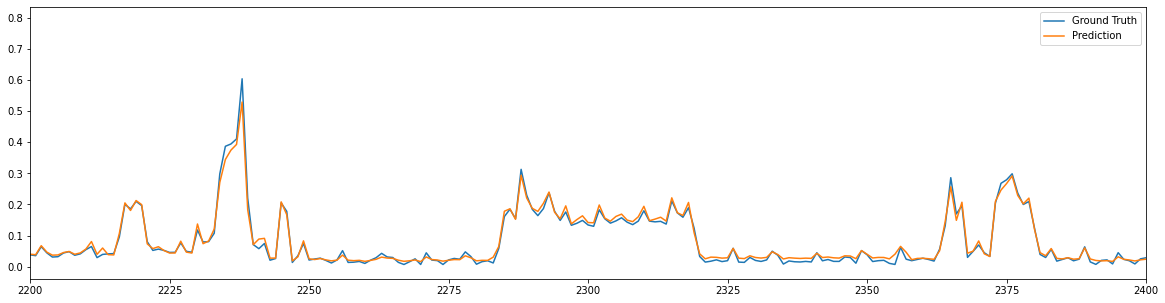

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()